In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

In [3]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    print('Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data('/Users/najeebkhan/Downloads/text8 (1).zip')
print('Data size', len(words))

Data size 17005207


In [5]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000


def build_dataset(words, vocabulary_size):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


In [7]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3084 originated -> 5239 anarchism
3084 originated -> 12 as
12 as -> 3084 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


In [8]:
print(batch)

[3084 3084   12   12    6    6  195  195]


### Creating the model

In [67]:
from tensorflow.contrib.tensorboard.plugins import projector
tf.reset_default_graph()

In [68]:
class SkipGram(object):
    
    def __init__(self,params):
        self.BATCH_SIZE = params['BATCH_SIZE']
        self.VOCAB_SIZE = params['VOCAB_SIZE']
        self.EMBED_SIZE = params['EMBED_SIZE']
        self.NUM_SAMPLED = params['NUM_SAMPLED']
        self.LEARNING_RATE =params['LEARNING_RATE']
        self.NUM_EPOCHS = params['NUM_EPOCHS']
        self.epoch_loss = []
        self._summary_writer,self._writer = None,None
        ## The following variables check for whether the elements 
        ## of the graph are not being added again and again into
        ## the graph definition. Lazy Loading!
        self._placeholder = None
        self._embeddings = None
        self._loss = None
        self._optimizer = None
        ## Model variable to save the number of steps
        self.global_step = tf.Variable(0,dtype=tf.int32,name="global_step",trainable=False)
        ## Model variable for summary op
        self.summary_op = None
    
    def _create_placeholders(self):
        if not self._placeholder:
            center_words = tf.placeholder(tf.int32,shape=[self.BATCH_SIZE],name='center_words')
            target_words = tf.placeholder(tf.int32,shape=[self.BATCH_SIZE,1],name='target_words')
            self._placeholder = (center_words,target_words)
        else:
            pass
        
    def _create_embeddings(self):
        if not self._embeddings:
            center_words,target_words = self._placeholder
            embeddings = tf.get_variable(name="embeddings",shape=[self.VOCAB_SIZE,self.EMBED_SIZE],
                                             initializer=tf.contrib.layers.xavier_initializer())
            embed = tf.nn.embedding_lookup(params=embeddings,ids=center_words)
            self._embeddings = embeddings,embed
    
    def _create_loss(self):
        if not self._loss:
            center_words,target_words = self._placeholder
            embeddings,embed = self._embeddings
            nce_weight = tf.get_variable(name="nce_weight",shape=[self.VOCAB_SIZE,self.EMBED_SIZE],
                                             initializer=tf.contrib.layers.xavier_initializer())
            nce_bias = tf.Variable(tf.zeros([self.VOCAB_SIZE]),name="nce_bias")
            self._loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,biases=nce_bias,
                                                      labels=target_words,inputs=embed,
                                                      num_sampled=self.NUM_SAMPLED,num_classes=self.VOCAB_SIZE))
        
    def _create_optimizer(self):
        if not self._optimizer:
            self._optimizer = tf.train.GradientDescentOptimizer(self.LEARNING_RATE).minimize(self._loss,global_step=
                                                                                            self.global_step)

    def train_model(self):
        center_words,target_words = self._placeholder
        embeddings,embed = self._embeddings
        init = tf.global_variables_initializer()
        ## Saving the model parameters with every 1000 epochs
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(init)
            ### TSNE for the word embeddings
            final_embed_matrix = sess.run(embeddings)
            embedding_var = tf.Variable(final_embed_matrix[:500], name='embedding')
            sess.run(embedding_var.initializer)
            config = projector.ProjectorConfig()
            self._summary_writer = tf.summary.FileWriter('graphs/tsne/')
            embedding = config.embeddings.add()
            embedding.tensor_name = embedding_var.name
            projector.visualize_embeddings(self._summary_writer, config)
            saver_embed = tf.train.Saver([embedding_var])
            saver_embed.save(sess,'graphs/tsne/skip-gram.ckpt', 1)
            ### Tensorboard graph
            self._writer = tf.summary.FileWriter('graphs/summary/',sess.graph)
            self.epoch_loss = []
            for epoch in range(1,self.NUM_EPOCHS+1):
                batch,labels = generate_batch(batch_size=self.BATCH_SIZE,num_skips=2,skip_window=1)
                _,l,summary = sess.run([self._optimizer,self._loss,self.summary_op],feed_dict=
                                       {center_words:batch,target_words:labels})
                if epoch%1000 == 0:
                    ## Saving the model
                    print('Saving Checkpoint...')
                    saver.save(sess,'checkpoints/skip_gram',global_step=self.global_step)
                    print('Epoch: {}\tLoss: {}'.format(epoch,l))
                    self._writer.add_summary(summary,global_step=epoch)
                self.epoch_loss.append(l)
    
    def _plot_loss(self):
        plt.plot(self.epoch_loss)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.title('Loss of SkipGram Model')
        plt.plot()
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss",self._loss)
            tf.summary.histogram("Histogram_Loss",self._loss)
            ## Merging the summaries to create a single op
            self.summary_op = tf.summary.merge_all()
        
    def _close_visulisations(self):
        self._writer.close()
        self._summary_writer.close()
    
        

In [69]:
params = {'BATCH_SIZE':128,
          'VOCAB_SIZE':50000,
          'EMBED_SIZE':128,
          'NUM_SAMPLED':64,
          'LEARNING_RATE':1.0,
          'NUM_EPOCHS':10000}

In [70]:
skipgram = SkipGram(params=params)

In [71]:
with tf.name_scope("Data"):
    skipgram._create_placeholders()

In [72]:
with tf.name_scope("Embeddings"):
    skipgram._create_embeddings()

In [73]:
with tf.name_scope("Loss"):
    skipgram._create_loss()

In [74]:
skipgram._create_optimizer()

In [75]:
skipgram._create_summaries()

In [76]:
skipgram.train_model()

Saving Checkpoint...
Epoch: 1000	Loss: 120.846176147
Saving Checkpoint...
Epoch: 2000	Loss: 69.1787033081
Saving Checkpoint...
Epoch: 3000	Loss: 56.7067909241
Saving Checkpoint...
Epoch: 4000	Loss: 25.1376800537
Saving Checkpoint...
Epoch: 5000	Loss: 18.7110424042
Saving Checkpoint...
Epoch: 6000	Loss: 48.1763687134
Saving Checkpoint...
Epoch: 7000	Loss: 13.5082378387
Saving Checkpoint...
Epoch: 8000	Loss: 25.4501342773
Saving Checkpoint...
Epoch: 9000	Loss: 24.7579956055
Saving Checkpoint...
Epoch: 10000	Loss: 9.17438411713


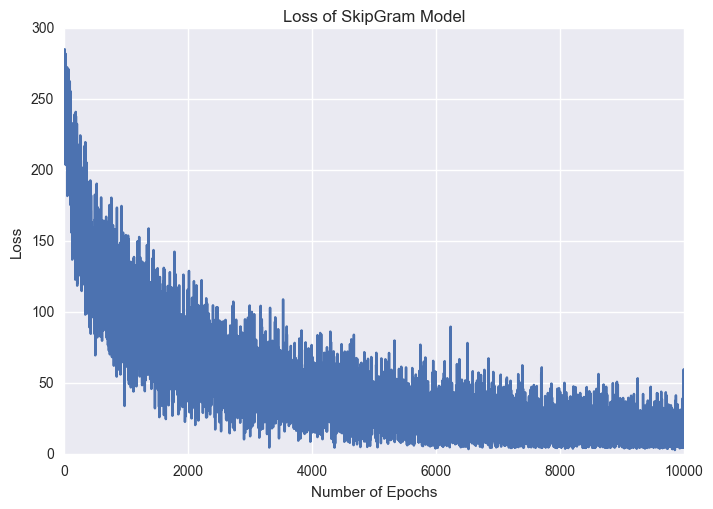

In [77]:
skipgram._plot_loss()

In [79]:
!tensorboard --logdir='graphs/summary/' --port 6006

Starting TensorBoard 41 on port 6006
(You can navigate to http://192.168.0.102:6006)
^CTraceback (most recent call last):
  File "/Users/najeebkhan/anaconda/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/Users/najeebkhan/anaconda/lib/python2.7/site-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/Users/najeebkhan/anaconda/lib/python2.7/SocketServer.py", line 231, in serve_forever
    poll_interval)
  File "/Users/najeebkhan/anaconda/lib/python2.7/SocketServer.py", line 150, in _eintr_retry
    return func(*args)
KeyboardInterrupt



In [80]:
skipgram._close_visulisations()